### This project is heavily inspired by [micrograd](https://github.com/karpathy/micrograd) repository by Andrej karpathy.

- The purpose of this notebook is to make the calculation of gradients easier to understand.
- It features animations of gradient calculations.

#


# Start of mGRAD


## Chapter 1


In [1]:
# ! conda install matplotlib imageio graphviz python-graphviz --yes
# ! pip install Pillow

### First We need to implement a class which can support automatic grad calculation

To do so, we need to be familiar with basic calculations

- Partial Derivative
- Chain Rule
- Using Partial Derivative in conjunction with Chain Rule


#### Some basic rules regarding Partial Derivative

- It is like a normal derivative, but we treat the rest of the values as constants except for the value against which we are calculating the derivative
- For example if f(x,y) = x+y, and we are calculating the partial derivative of f(x,y) with respect to x the y will be considered a constant. The result will be ∂f/∂x = 1 +0, because the derivative of x is 1 and the derivative of a constant is 0
- For f(x,y) = x \* y, partial derivative of x will be y (in accordance with the product rule, treating y as a constant)


#### Some basic rules regrading Chain Rule

- Lets say you have a f(x,y) = x+y, where x is defined as f(a) = t^2
- Now we want 3 thing derivative of f(x,y) in respect of ∂x,∂y,∂t
- We can calculate partial derivate ∂x,∂y easily, but what about ∂t
- To do so we need to calculate ∂x,∂y of f(x,y)
- Then we need to calculate ∂t of x, which is 2t because of power rule
- After that we multiply ∂f/∂x \* ∂x/∂t to get ∂f/∂t
- So the final results will be ∂f/∂x = 1, ∂f/∂y = 1, ∂f/∂t = 1 \* 2t = 2t


#### Now what if x, y was both depended on t, or t has multiple influence on the function ?

- In this case, lets say f(x,y) = x+y, where x is defined as f(a) = t^2 and y is defined as f(b) = t
- All calculation remains same, but need to calculate new ∂y/∂t which is 1
- Now what we need to do for ∂f/∂t is add all intermediate derivatives
- Which will be ∂f/∂t = (∂f/∂x _ ∂x/∂t) + (∂f/∂y _ ∂y/∂t) = (1 _ 2t) + (1 _ 1) = 2t+1
- You can view the awesome lecture given below by The Organic Chemistry Tutor channel for a more in-depth understanding
- [Chain Rule With Partial Derivatives](https://youtu.be/XipB_uEexF0?list=PLLUZoeliBUH16I17v0oN-DH8oSGYc2Uvc)


#### The Node Class is the heart of all operations

When used,

- Keeps tracks of all operation and outcome of those operations.
- Creates a Directed Acyclic Graph.
- Calculates grad/gradients of all of the point exists in the graph.
- Also as a bonus, it can animate the gradients calculation process and also lets you save it as gif.


In [2]:
import random
import math
from typing import Annotated

# All of these import statement is only used for Display Purpose
import os
import time
import imageio
from PIL import Image
from io import BytesIO
from graphviz import Digraph
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
# All of these import statement is only used for Display Purpose


class Node:

    def __init__(self, value: Annotated[int, float], type: Annotated[None, str] = None):
        assert isinstance(value, (int, float)), f"for now only int/float; given {type(value)},{value}"
        self._value = float(value)
        self._parent_a = None
        self._parent_b = None
        self._operation = None
        self._grad = 0.0
        self._backward = lambda: None
        self._type = type

    def __add__(self, other, r=False):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self._value + other._value)

        out._operation = '+'
        if not r:
            out._parent_a = self
            out._parent_b = other
        else:
            out._parent_a = other
            out._parent_b = self

        def backward():
            self._grad += out._grad
            other._grad += out._grad

        out._backward = backward
        return out

    def __mul__(self, other, r=False):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self._value * other._value)

        out._operation = '*'
        if not r:
            out._parent_a = self
            out._parent_b = other
        else:
            out._parent_a = other
            out._parent_b = self

        def backward():
            self._grad += other._value * out._grad
            other._grad += self._value * out._grad

        out._backward = backward
        return out

    def __neg__(self):
        return self.__mul__(-1, True)

    def __radd__(self, other):
        return self.__add__(other, True)

    def __rmul__(self, other):
        return self.__mul__(other, True)

    def __sub__(self, other, r=False):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self._value - other._value if not r else other._value - self._value)

        out._operation = '-'
        if not r:
            out._parent_a = self
            out._parent_b = other
        else:
            out._parent_a = other
            out._parent_b = self

        def backward():
            self._grad += out._grad
            other._grad += out._grad

        out._backward = backward
        return out

    def __rsub__(self, other):
        return self.__sub__(other, True)

    @classmethod
    def __power(cls, a, b):
        return abs(a ** b) * -1 if b % 2 != 0 else abs(a ** b)

    def __pow__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.__power(self._value, other._value))

        out._operation = '**'
        out._parent_a = self
        out._parent_b = other

        def backward():
            self._grad += (other._value * self.__power(self._value, other._value - 1)) * out._grad
            other._grad += ((self.__power(self._value, other._value)) * math.log(self._value, 2.71828)) * out._grad if self._value > 0 else 0

        out._backward = backward
        return out

    def __truediv__(self, other, r=False):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self._value / other._value if not r else other._value / self._value)

        out._operation = '/'
        if not r:
            out._parent_a = self
            out._parent_b = other
        else:
            out._parent_a = other
            out._parent_b = self

        def backward():
            self._grad += (-self._value / (other._value * 2)) * out._grad
            other._grad += (self._value / other._value) * out._grad if other._value > 0 else 0

        out._backward = backward
        return out

    def __rtruediv__(self, other):
        return self.__truediv__(other, True)

    def __floor__(self):
        if self._value >= 0:
            out = Node(int(self._value))
        else:
            out = Node(int(self._value) - 1)

        out._operation = 'floor'
        out._parent_a = self

        def backward():
            self._grad += 1 * out._grad if self._value == out._value else 0

        out._backward = backward
        return out

    def __floordiv__(self, other, r=False):
        return (self / other).__floor__() if not r else (other / self).__floor__()

    def __rfloordiv__(self, other):
        return self.__floordiv__(other, True)

    def relu(self):
        out = Node(0 if self._value < 0 else self._value)

        out._operation = 'ReLU'
        out._parent_a = self

        def backward():
            self._grad += (self._value > 0) * out._grad

        out._backward = backward
        return out

    def tanh(self):
        out = Node((math.exp(2 * self._value) - 1) / (math.exp(2 * self._value) + 1))

        out._operation = 'Tanh'
        out._parent_a = self

        def _backward():
            self._grad += (1 - out._value ** 2) * out._grad

        out._backward = _backward
        return out

    def __abs__(self):
        return self * -1 if self._value < 0 else self

    def __repr__(self) -> str:
        value = f'{self._value:.4f}'
        grad = f'{float(self._grad):.4}'
        left = f'{self._parent_a._value:.4f}' if self._parent_a else None
        right = f'{self._parent_b._value:.4f}' if self._parent_b else None

        if not self._parent_a:
            return f'({value} [{self._type if self._type else "leaf"}] | grad = {grad})'
        elif right:
            return f'({value} [({left}){self._operation}({right})] | grad = {grad})'
        else:
            return f'({value} [{self._operation}({left})={value}] | grad = {grad})'

    def dfs_with_iteration_with_topological_short(self, relations=True):
        visited = set()
        stack = [self]
        nodes = []
        relation = []
        while stack:
            current = stack.pop()
            if current not in visited:
                nodes.append(current)
                visited.add(current)

                if current._parent_a:
                    relation.append((current, current._parent_a, current._operation)) if relations else None
                    stack.append(current._parent_a)

                if current._parent_b:
                    relation.append((current, current._parent_b, current._operation)) if relations else None
                    stack.append(current._parent_b)

        return nodes, relation

    def draw_graph(self, high_dp=False):
        return self.__draw_graph(high_dp)

    def __draw_graph(self, current_node=None, label="", grad_done=[], high_dp=False):

        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR', 'dpi': '150' if high_dp else ''})
        dot.attr(label=label, labelloc='t', fontsize='20', )

        nodes, edges = self.dfs_with_iteration_with_topological_short()

        current_child = set()

        def style(node: Node, color="transparent", override=False):
            if not override:
                if node._type == "input":
                    color = "orange"
                elif node._type == "weight":
                    color = "#51d680"
                elif node._type == "bias":
                    color = "#aab832"
            return {"style": 'filled', "fillcolor": color}

        for node in nodes:
            if node in grad_done:
                dot.node(name=str(id(node)), label=str(node)[1:-1], shape='record', **style(node, "lightblue"))
                grad_done.append(node._parent_a) if (node._parent_a and node._parent_a._parent_a is None) else None
                grad_done.append(node._parent_b) if (node._parent_b and node._parent_b._parent_b is None) else None
                continue

            if current_node == node:
                dot.node(name=str(id(node)), label=str(node)[1:-1], shape='record', **style(node, "lightcoral", True))
                current_child.add(node._parent_a) if node._parent_a else None
                current_child.add(node._parent_b) if node._parent_b else None
                continue

            if node in current_child:
                dot.node(name=str(id(node)), label=str(node)[1:-1], shape='record', **style(node, "lightcoral", True))
                continue

            dot.node(name=str(id(node)), label=str(node)[1:-1], shape='record', **style(node))

        covered_edges = []

        for edge in edges:

            operation = edge[2]
            operation_id = (str(id(edge[0])) + operation)

            if operation_id not in covered_edges:
                dot.node(name=operation_id, label=operation)
                dot.edge(operation_id, str(id(edge[0])))
                covered_edges.append(operation_id)
            dot.edge(str(id(edge[1])), operation_id)

        return Image.open(BytesIO(dot.pipe(format='png')))

    def backward(self, make_zero_grad=True, animate=False, animation_delay: float = .2, generate_gif=False, high_dp=False):

        sorted, _ = self.dfs_with_iteration_with_topological_short(relations=False)
        calculated = []
        frames = []

        if make_zero_grad:
            for node in sorted:
                node._grad = 0

        self._grad = 1

        for node in sorted:

            if animate:
                clear_output(wait=True)
                frame = self.__draw_graph(grad_done=calculated, label="Calculating Grad", current_node=node, high_dp=high_dp)
                display(frame)
                frames.append(frame) if generate_gif else None
                node._backward()
                calculated.append(node)
                time.sleep(animation_delay)
            else:
                node._backward()

        if animate:
            clear_output(wait=True)
            frame = self.__draw_graph(grad_done=calculated, label="Grad Calculation Completed", current_node=node, high_dp=high_dp)
            display(frame)
            frames.append(frame) if generate_gif else None
            if generate_gif:
                name = "backward.gif"
                os.makedirs("./gif", exist_ok=True)
                for _ in range(2):
                    frames.append(frames[-1])
                imageio.mimsave(f"./gif/{name}", frames, duration=int(animation_delay * 1000), loop=0)

#### A simple neuron

Lets try to create a simple neuron using node class, which

- Has two Input (x1,x2)
- Has two Weights (w1,w2)
- Inputs are multiplied by Weights and added with one Bias (b)
- Has an activation function (ReLU)
- Animates the gradient calculation process


In [3]:
x1 = Node(0.5, "input")
x2 = Node(-0.5, "input")
w1 = Node(2, "weight")
w2 = Node(3, "weight")
b = Node(4, "bias")
n = (x1*w1 + x2*w2 + b).relu()  # Here n is considered as a single neuron

Let's visualize how the expression looks as a Directed Acyclic Graph.


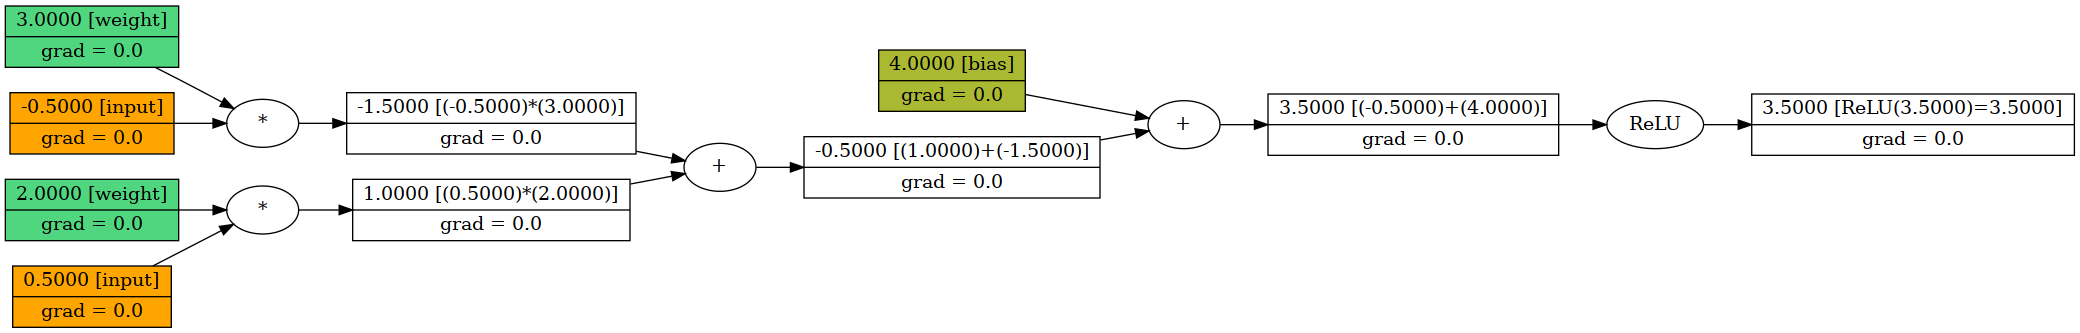

In [4]:
n.draw_graph(high_dp=True)

Now let's visualize how the automatic gradients calculation works.


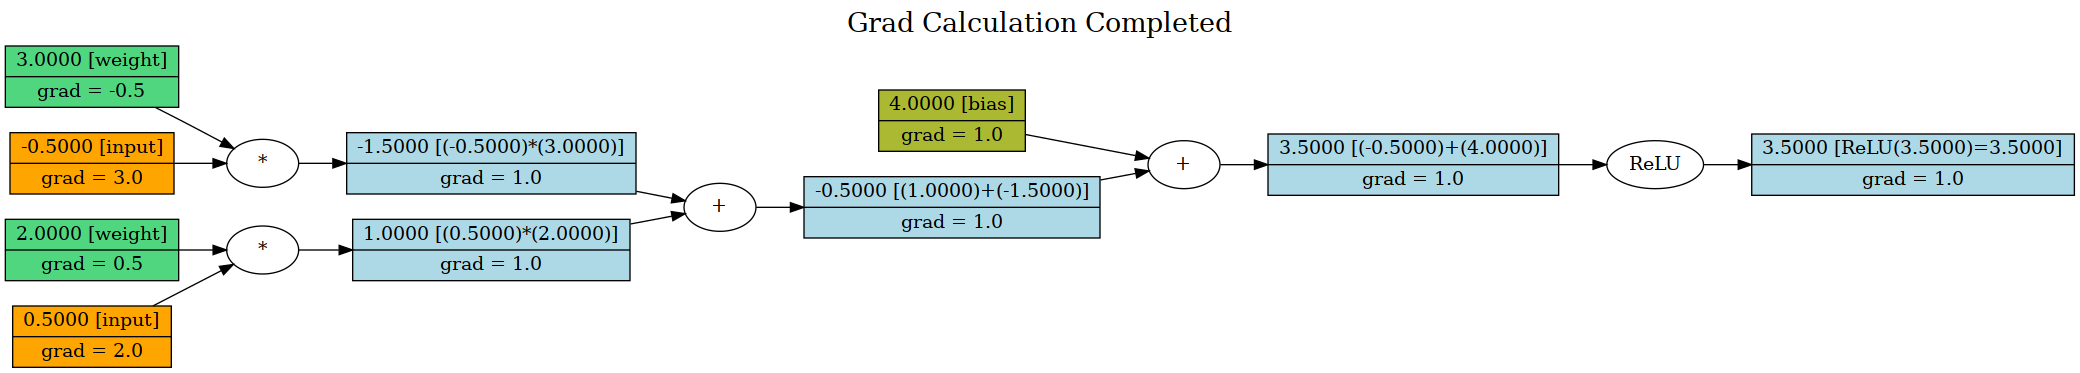

In [5]:
n.backward(animate=True)

Now we will try to minimize the output of the neuron (the value of n) by using gradients of its weights and bias.
Please note,

- We will update the weights and bias.
- We will not update the input because our goal is to estimate a value based on the input by adjusting the weights and bias.


In [6]:
# We will try to make the output closer to zero to view if grads actually works!
parameters = [w1, w2, b]
for _ in range(5):
    print(f'current value: {n._value}')
    n.backward()
    for parameter in parameters:
        parameter._value -= 0.3 * parameter._grad
    n = (x1*w1 + x2*w2 + b).relu()  # we need to build the expression again to see the influence of the updates we just made
print(f'current value: {n._value}')

current value: 3.5
current value: 3.0500000000000003
current value: 2.6000000000000005
current value: 2.150000000000001
current value: 1.700000000000001
current value: 1.2500000000000013


Let's visualize again how the expression looks now after we updated the values (weights and bias)


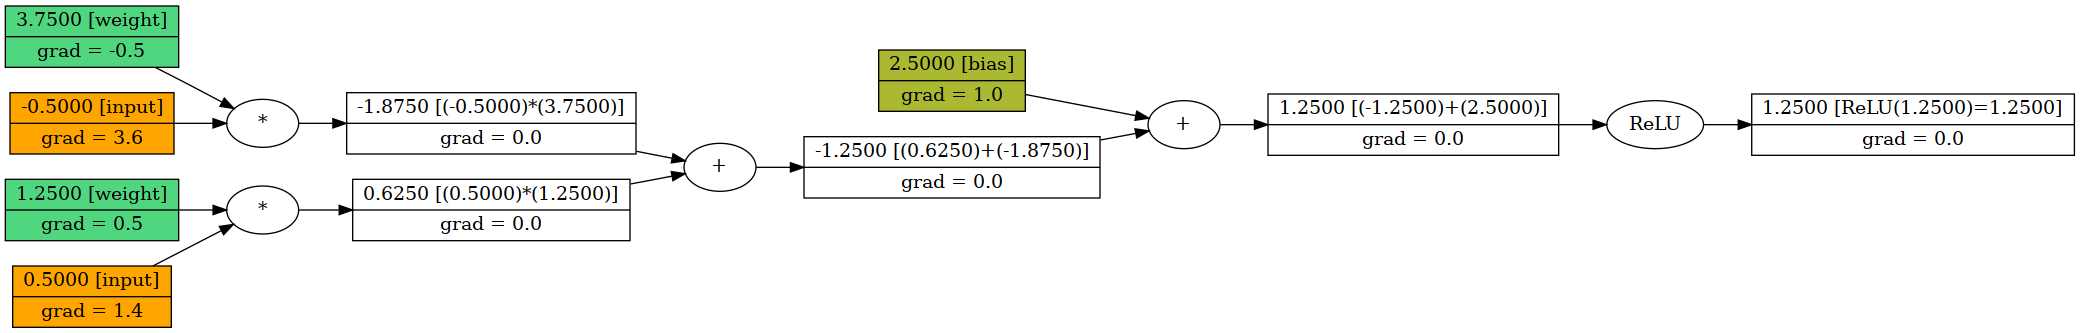

In [7]:
n.draw_graph(high_dp=True)

As you see the value indeed reduced, it was initially 3.5 and after updating weights and bias it became 1.25.  
If we did this a few more times the value will be eventually zero.


#


## Chapter 2


#### MultiLayer Perceptron (MLP)

- Stacks multiple neurons and create a layer
- Stacking multiple layers we can crate a multilayer perceptron model


In [8]:
class Neuron:
    def __init__(self, shape_of_input, activation_type: str = "relu"):
        self._weights = [Node(random.uniform(-1, 1)) for _ in range(shape_of_input)]
        self._bias = Node(0)
        self._activation_type = activation_type

    def __call__(self, inputs: list, non_liner=True) -> Node:
        out = (self._weights[0] * inputs[0])
        for w, i in zip(self._weights[1:], inputs[1:]):
            out += (w * i)
        out += self._bias
        return (out.tanh() if self._activation_type == "tanh" else out.relu()) if non_liner else out

    def parameters(self) -> list:
        return self._weights + [self._bias]


class Layer:
    def __init__(self, input: int, output: int, non_liner=True, activation="relu"):
        self._neurons = [Neuron(input, activation) for _ in range(output)]
        self._shape_of_input = input
        self._non_liner = non_liner
        self._activation = activation

    def __call__(self, input) -> list[Node] | Node:
        out = [neuron(input, self._non_liner) for neuron in self._neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self) -> list:
        return [parameter for neuron in self._neurons for parameter in neuron.parameters()]

    def __repr__(self) -> str:
        return f"(neurons: {len(self._neurons)}, shape: {self._shape_of_input}, parameters: {len(self.parameters())}, activation: {self._activation if self._non_liner else "none"})"


class MultiLayerPerception:
    def __init__(self, layout: list[int]):
        self.__layers = [Layer(layout[i], layout[i+1]) for i in range(0, len(layout)-1)]
        self.__layers[-1]._non_liner = False

    def __call__(self, input: list[float | int]):
        for layer in self.__layers:
            result = layer(input)
            input = result
        return input

    def parameters(self):
        return [parameter for layer in self.__layers for parameter in layer.parameters()]

    def zero_grad(self):
        for parameter in self.parameters():
            parameter._grad = 0

    def __repr__(self) -> str:
        return str(self.__layers)

# End of mGRAD


#


#### Dataset to test MLP

- The function 'make_moons' makes two interleaving half-circles
- The function 'make_moons' returns (x,y) coordinates along with their label
- The function 'plot_contour_decision_boundary' will plot the decision boundary of created/trained model


In [9]:
def make_moons(n_samples):
    p = int((n_samples//2)+1)
    outer_circle = []
    inner_circle = []
    for i in range(0, p):
        theta = i * math.pi / p
        outer_circle.append((math.cos(theta), math.sin(theta)))
        inner_circle.append((.4 - math.cos(theta), 0.4 - math.sin(theta)))

    xy = outer_circle + inner_circle
    x, y = zip(*xy)
    # l will be the color map for x, y
    l = ([-1] * len(outer_circle)) + ([1] * len(inner_circle))
    return x, y, l


def plot_contour_decision_boundary():
    """This will plot the decision boundary learned by the model."""
    """Note: This function is meant to be called after training, else will raise exception."""
    def mesh(_x, _y, model, step=1):
        x_min, x_max = min(_x) - 1, max(_x) + 1
        y_min, y_max = min(_y) - 1, max(_y) + 1

        def arrange(_min, _max, step):
            gen = [_min]
            for _ in range(int((_max-_min)//step)):
                gen.append(round(float(gen[-1]+step), 2))
            return gen
        xx = arrange(x_min, x_max, step)
        yy = arrange(y_min, y_max, step)
        xm = [xx for _ in range(len(yy))]
        ym = [[i]*len(xx) for i in yy]
        row = len(xm[0])
        column = len(xm)
        src = []
        for i in range(column):
            temp = []
            for j in range(row):
                input_ = [xm[i][j], ym[i][j]]
                output = model(input_)
                temp.append(output._value > 0)
            src.append(temp)
        return xm, ym, src
    x, y, l = make_moons(n_samples=100)
    xm, ym, scr = mesh(x, y, model, .3)
    plt.figure(figsize=(5, 4))
    plt.contourf(xm, ym, scr, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(x, y, c=l, s=40, cmap=plt.cm.Spectral)
    plt.show()

#### Creating an MLP model

- Takes two input
- Has two hidden layer
- First hidden layer has 20 neurons and second hidden layer has 16 neurons
- All hidden layers have ReLU actuation function
- The model will output one single output variable
- The model will take input the (x,y) coordinates generated by 'make_moons' data generator function and try to predict the labels of the (x,y) coordinates


In [10]:
random.seed(27)  # To make results always constant

model = MultiLayerPerception([2, 20, 16, 1])  # 2 Layer MLP

print(model)
print("Parameters:", len(model.parameters()))

[(neurons: 20, shape: 2, parameters: 60, activation: relu), (neurons: 16, shape: 20, parameters: 336, activation: relu), (neurons: 1, shape: 16, parameters: 17, activation: none)]
Parameters: 413


#### Visualizing the 'make_moons' data generator


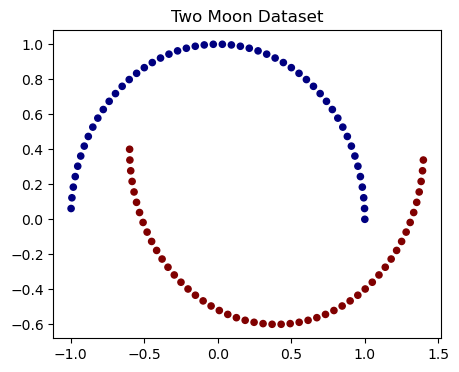

In [11]:
x, y, label = make_moons(n_samples=100)
plt.figure(figsize=(5, 4))
plt.scatter(x, y, c=label, s=20, cmap='jet')
plt.title('Two Moon Dataset')
plt.show()

In [12]:
def loss_function(x1, x2, label):

    scores = [model([x, y]) for x, y, in zip(x1, x2)]

    # svm "max-margin" loss
    losses = [(1 + -original_label*predicted).relu() for original_label, predicted in zip(label, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(original_label > 0) == (predicted._value > 0) for original_label, predicted in zip(label, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


loss_function(x, y, label)

((0.9234 [(0.9109)+(0.0125)] | grad = 0.0), 0.6470588235294118)

In [13]:
initial_learning_rate = 1
decay_rate = .9
decay_step = 15
num_epochs = 200

for k in range(num_epochs):

    # forward pass
    loss, accuracy = loss_function(x, y, label)

    # backward pass
    loss.backward()
    learning_rate = initial_learning_rate * (decay_rate ** (k // decay_step))

    # update wights and biases based on gradients
    for p in model.parameters():
        p._value -= learning_rate * p._grad

    if k % 10 == 0:  # printing loss along with accuracy and learning rate after every 10 epoch
        print(f"epoch {k}, loss: {loss._value}, accuracy: {accuracy*100:.4}%, learning_rate: {learning_rate:.4}")

        # if below line is uncommented then it will plot every decision boundary currently assumed by model

        # plot_contour_decision_boundary()

epoch 0, loss: 0.9234142567507213, accuracy: 64.71%, learning_rate: 1.0
epoch 10, loss: 0.25614455727777663, accuracy: 89.22%, learning_rate: 1.0
epoch 20, loss: 0.18812950485232685, accuracy: 92.16%, learning_rate: 0.9
epoch 30, loss: 0.15607600731163537, accuracy: 94.12%, learning_rate: 0.81
epoch 40, loss: 0.15362345886018597, accuracy: 94.12%, learning_rate: 0.81
epoch 50, loss: 0.101929434551958, accuracy: 96.08%, learning_rate: 0.729
epoch 60, loss: 0.07980863680110598, accuracy: 98.04%, learning_rate: 0.6561
epoch 70, loss: 0.06714381465097202, accuracy: 98.04%, learning_rate: 0.6561
epoch 80, loss: 0.06456027522415157, accuracy: 98.04%, learning_rate: 0.5905
epoch 90, loss: 0.05700387906926453, accuracy: 98.04%, learning_rate: 0.5314
epoch 100, loss: 0.04676341426338824, accuracy: 99.02%, learning_rate: 0.5314
epoch 110, loss: 0.03429984306450522, accuracy: 100.0%, learning_rate: 0.4783
epoch 120, loss: 0.07513996415943182, accuracy: 97.06%, learning_rate: 0.4305
epoch 130, los

#### Visualizing Decision Boundary of trained model


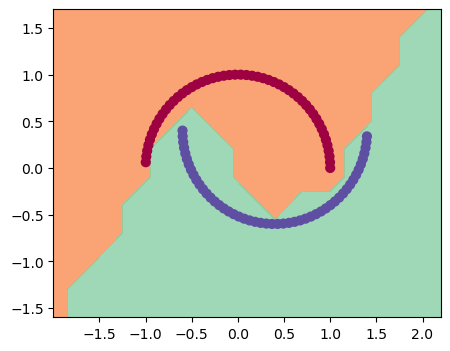

In [14]:
plot_contour_decision_boundary()

## Thank you.
